# [E11] 뉴스 기사 요약하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#데이터 수집하기, 아래 링크 기사데이터 사용, 데이터 다운로드 하기

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
79856,Guj firm to give 'Made in India' phones to its...,Amidst ongoing tensions between India and Chin...
2431,FBI probed whether Trump was secretly working ...,The Federal Bureau of Investigation opened a p...
14848,Pedestrian killed by windowpane that fell 250 ...,A man was killed after he was hit by a windowp...
26574,Nana Patekar to star in 'Housefull 4','Housefull 4' producer Sajid Nadiadwala has co...
63897,CBI registers FIR for misuse of PM's name in l...,The CBI has registered a case against unidenti...
90385,Award-winning mountaineer Ueli Steck cremated ...,The body of award-winning Swiss mountaineer Ue...
14034,Odisha orders evacuation of areas ahead of cyc...,Odisha government has ordered an immediate eva...
49384,"Pakistan minister shoots wife, kills himself",Pakistani provincial minister Mir Hazar Bijara...
80744,Trump hints at changing position on Paris clim...,US President Donald Trump on Thursday suggeste...
51214,Researchers patent glasses which can prevent m...,University of Michigan researchers have patent...


In [4]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [5]:
data = data[['text','headlines']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,text,headlines
88264,Actor Tiger Shroff took to Twitter to share th...,Tiger Shroff unveils first look poster of 'Ram...
86965,"Game of Thrones actor Jason Momoa, who played ...",Game of Thrones' Khal Drogo does a war cry wit...
36073,Facebook added nearly $21 billion in market va...,Facebook gained $21 billion during Zuckerberg'...
71276,"Actress Riya Sen, while responding to rumours ...",Expected pregnancy speculation at time of my w...
61550,Former Indian captain MS Dhoni officially laun...,MS Dhoni launches cricket academy in Dubai
12950,The Enforcement Directorate on Thursday said i...,"ED issues notice to NDTV over Ã¢ÂÂ¹4,300 cror..."
5951,Former two-time Chief Executive Officer (CEO) ...,Former two-time CEO of Jet Airways quits as ad...
84290,Financial services major Barclays and four for...,"Barclays, former top execs charged with fraud ..."
30891,Actress Aishwarya Rai Bachchan has said if a w...,Applying makeup doesn't mean you don't have br...
35100,MI wicketkeeper Ishan Kishan on Tuesday suffer...,MI keeper Kishan hit on the face by Hardik Pan...


In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [8]:
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


In [9]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [14]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [15]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [16]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
data.isnull().sum()

text         0
headlines    0
dtype: int64

In [18]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


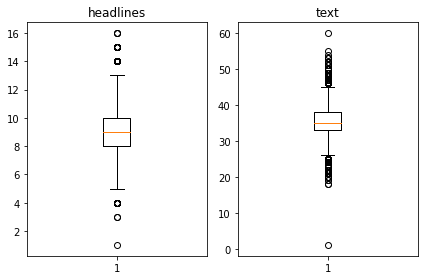

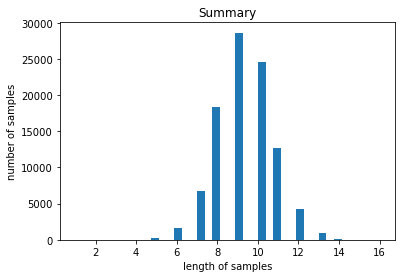

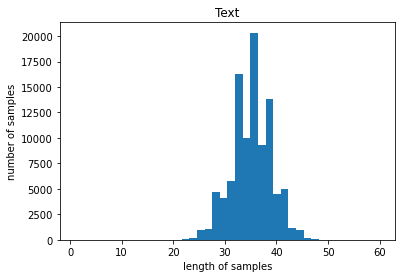

In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
text_max_len = 50
summary_max_len = 12

In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [23]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [24]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 97169


In [25]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [26]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [27]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[29052 54674 64399 ... 53718 12899 85792]


In [28]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [29]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19433


In [30]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


In [31]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [32]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69412
등장 빈도가 6번 이하인 희귀 단어의 수: 47354
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22058
단어 집합에서 희귀 단어의 비율: 68.22163314700627
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.529150931814726


In [33]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2, 3360, 3230, 1483, 183, 62, 3360, 636, 1957, 19, 399, 2369, 2969, 65, 6669, 2086, 764, 1508, 1361, 2970, 264, 1717, 3563, 143, 2086, 6, 347, 1521, 100, 528, 551, 5433, 2384], [3, 13, 64, 5, 247, 898, 692, 155, 4402, 23, 420, 1023, 19, 200, 4402, 4272, 1817, 898, 3, 151, 729, 65, 4402, 1885, 119, 1817, 898, 482, 812, 242], [409, 7121, 2107, 72, 966, 2971, 88, 12, 1057, 5778, 72, 86, 1063, 190, 901, 218, 62, 3393, 9, 3130, 6512, 43, 1484, 4896, 1502, 43, 7227, 972, 295, 1159, 377]]


In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30038
등장 빈도가 5번 이하인 희귀 단어의 수: 19658
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10380
단어 집합에서 희귀 단어의 비율: 65.44377122311738
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.702828697454323


In [37]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 8, 1624, 180, 1342, 449, 7], [1, 64, 27, 348, 623, 3, 340, 13, 101, 581], [1, 183, 81, 5, 1482, 185, 63, 4, 55], [1, 127, 416, 632, 41, 160, 70, 15, 586, 246], [1, 20, 44, 576, 39, 27, 88, 131, 981, 916]]
target
decoder  [[8, 1624, 180, 1342, 449, 7, 2], [64, 27, 348, 623, 3, 340, 13, 101, 581, 2], [183, 81, 5, 1482, 185, 63, 4, 55, 2], [127, 416, 632, 41, 160, 70, 15, 586, 246, 2], [20, 44, 576, 39, 27, 88, 131, 981, 916, 2]]


In [38]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 17
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 77719
훈련 레이블의 개수 : 77719
테스트 데이터의 개수 : 19432
테스트 레이블의 개수 : 19432


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

# 어텐션 메커니즘 사용 (추상적 요약하기)

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [41]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [43]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [44]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [45]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
304/304 [==============================] - 101s 332ms/step - loss: 3.8546 - val_loss: 3.5258
Epoch 2/50
304/304 [==============================] - 101s 331ms/step - loss: 3.3807 - val_loss: 3.2413
Epoch 3/50
304/304 [==============================] - 99s 327ms/step - loss: 3.1423 - val_loss: 3.0431
Epoch 4/50
304/304 [==============================] - 99s 326ms/step - loss: 2.9444 - val_loss: 2.8849
Epoch 5/50
304/304 [==============================] - 99s 327ms/step - loss: 2.7958 - val_loss: 2.7814
Epoch 6/50
304/304 [==============================] - 99s 326ms/step - loss: 2.6834 - val_loss: 2.6996
Epoch 7/50
304/304 [==============================] - 99s 327ms/step - loss: 2.5916 - val_loss: 2.6432
Epoch 8/50
304/304 [==============================] - 99s 326ms/step - loss: 2.5139 - val_loss: 2.5846
Epoch 9/50
304/304 [==============================] - 99s 327ms/step - loss: 2.4460 - val_loss: 2.5478
Epoch 10/50
304/304 [==============================] - 99s 327ms/step -

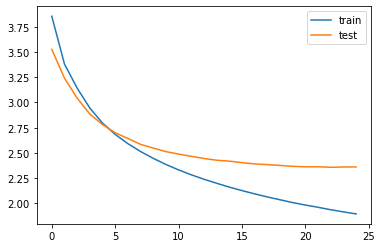

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현

In [47]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [48]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [49]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [50]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 모델 결과 테스트

In [51]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [52]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : restrictions imposed parts srinagar maintain law order situation militant killed shootout friday region schools colleges city closed day train services also suspended al qaeda militant killed policeman martyred shootout 
실제 요약 : in after killing 
예측 요약 :  over quota in days


원문 : people killed others wounded government air strikes syria eastern two weeks medical aid group doctors without borders said although united nations security council approved day ceasefire resolution syria rebel fighters syrian government forces accused breaking 
실제 요약 : people killed in syrian in weeks 
예측 요약 :  killed in air strikes in syria


원문 : authorities russia found bag containing severed human hands near city per reports local first spotted single hand eventually led discovery bag island river investigation incident launched 
실제 요약 : bag hands found in russia 
예측 요약 :  kg of kg found in


원문 : year old accused sexually assaulting four year old girl found hanging tree tamil nadu sunday police said

예측 요약 :  china prez xi to


원문 : club bowler deliberately threw ball boundary deny opposition player chance score maiden hundred apologised actions left batsman jay stranded five runs latter team needed two runs win handed nine match ban 
실제 요약 : banned bowler apologises for batsman century 
예측 요약 :  player ball with ball


원문 : year old attempted suicide wednesday jumping th floor building escape torture employer haryana girl burn injury marks body rescued fell bird net th floor doctors reportedly said girl long 
실제 요약 : year old jumps from th floor to escape 
예측 요약 :  year old jumps off building on floor floor


원문 : actress kangana ranaut chhattisgarh cm raman singh monday launched smartphone distribution scheme called mobile tihar yojana scheme includes distribution smartphones lakh women lakh children setting new mobile towers singh said government working towards improving network connectivity youth smartphones 
실제 요약 : kangana chhattisgarh cm launch mobile scheme 
예측 요약 :  gujar

## 50개의 샘플 비교하기
비슷한 단어를 맞추기는 했지만 대부분 틀린 답이 많은것으로 보인다. 
여러가지 개선방안이 있지만 노드에서 제안한 추출적 요약을 통해 비교해보기로 한다.

# summa를 이용하여 추출적 요약

In [1]:
import requests
from summa.summarizer import summarize
import urllib.request
import numpy as np
import pandas as pd

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data = data[['text', 'headlines']]
text = data['text']

In [4]:
text.head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
Name: text, dtype: object

In [5]:
print(text[:1500])

0       Saurav Kant, an alumnus of upGrad and IIIT-B's...
1       Kunal Shah's credit card bill payment platform...
2       New Zealand defeated India by 8 wickets in the...
3       With Aegon Life iTerm Insurance plan, customer...
4       Speaking about the sexual harassment allegatio...
                              ...                        
1495    India head coach Ravi Shastri has said that he...
1496    Italian tennis player Andreas Seppi ensured hi...
1497    World number three Roger Federer was stopped b...
1498    A cutout of TMC chief and West Bengal CM Mamat...
1499    A Delhi court on Saturday pulled up Delhi Poli...
Name: text, Length: 1500, dtype: object


# summarize 사용하기
- text (str) : 요약할 테스트.
 - ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
 - words (int or None, optional) – 출력에 포함할 단어 수.
 - 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
 - split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [8]:
print('Summary:')
summarize(text[1], ratio=0.5)

Summary:


'Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.'

In [9]:
print('Summary:')
print(summarize(text[1], ratio=0.5, split=True))

Summary:
['Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.']


In [11]:
print('Summary:')
print(summarize(text[1], words=50))

Summary:
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year.
Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [12]:
print('Summary:')
print(summarize(text[1], words=20))

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [14]:
print('Summary:')
print(summarize(text[10], words=20))

Summary:
Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.


# 루브릭
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
 - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
 -  모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
 - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

# 결과
 - 친절한 노드 설명으로 크게 어려움 없이 뉴스 데이터의 전처리 과정과 모델 구성을 통해 학습을 수행할 수 있었다.
 - 지난 간단한 모델에 비해 학습시간이 크게 늘어난것에 대해 다양한 시도를 하는데 있어 시간적 어려움이 있었다.
 - 추출적(Extrative) 요약과 추상적(Abstractive) 요약 결과를 비교, 이해하는데 큰 도움이 되었다.
 - summarize 모델을 통해 추출적 요약을 쉽게 결과 도출을 하였으며 기존 문장에서 추출하는것이므로 기본적인 성능이 어느정도 보장됨을 알수있었다.